# Summary

Need to work through a small example before scaling up. The goal
here is to predict which repos at time $t_{i}$ will be healthy or unhealthy
at time $t_{i+1}$. The algorithm that I implement has to work on Spark. Going
to do spark later once I figure out the game plan.

In [1]:
ls ~/code/*.parquet

/Users/tylerbrown/code/author_2019-04-20_0.parquet
/Users/tylerbrown/code/commit_file_2019-04-20_0.parquet
/Users/tylerbrown/code/commit_file_2019-04-20_1.parquet
/Users/tylerbrown/code/contrib_2019-04-20_0.parquet
/Users/tylerbrown/code/info_2019-04-20_0.parquet
/Users/tylerbrown/code/meta_2019-04-20_0.parquet


## Dependencies

In [2]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


## Load Data

Databases have been consolidated and switched to Parquet files with
no more than 2e6 records in each.

In [3]:
commits = pd.read_parquet('/Users/tylerbrown/code/commit_file_2019-04-20_0.parquet', 'pyarrow').append(
    pd.read_parquet('/Users/tylerbrown/code/commit_file_2019-04-20_1.parquet', 'pyarrow')
)
commits.shape

/Users/tylerbrown/miniconda3/envs/rose/lib/python3.6/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/Users/tylerbrown/miniconda3/envs/rose/lib/python3.6/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/Users/tylerbrown/miniconda3/envs/rose/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


(2327964, 5)

In [4]:
meta = pd.read_parquet('/Users/tylerbrown/code/meta_2019-04-20_0.parquet', 'pyarrow')
meta.shape

(928779, 3)

In [5]:
author = pd.read_parquet('/Users/tylerbrown/code/author_2019-04-20_0.parquet')
author.shape

(928779, 4)

In [6]:
meta.head()

,commit_hash,owner_name,project_name
0,8c2ffd9174779014c3fe1f96d9dc3641d9175f00,torvalds,linux
1,17403fa277eda1328a7026dfca7e40249f27dc6b,torvalds,linux
2,231c807a60715312e2a93a001cc9be9b888bc350,torvalds,linux
3,49ef015632ab3fcc19b2cb37b199d6d7ebcfa5f8,torvalds,linux
4,19caf581ba441659f1a71e9a5baed032fdcfceef,torvalds,linux


# Hypotheses

We need to generate some hypotheses related to RepoHealth. We can
then test those hypotheses with some fairly straight forward statistical
modeling. 

$F = ma$, repo health $\Rightarrow a = \frac{F}{m}$ where acceleration $a$ is
my definition for repo health. This is the shark hypotheses, software has to keep
moving or it dies. We can measure the level of acceleration by measuring the amplitude.
We have to normalize acceleration by mass to compare across repos.

$H1_a:$ Amplitude $\uparrow$, repo health (acceleration) $\uparrow$

Since 'repo health' isn't something we can directly measure, we have
to use a proxy measure or instrument variable. I use acceleration as a 
proxy for repo health. Substantively, we shouldn't see any projects that 
we know are 'healthy' violate $H1_a$. 

# Data Preprocessing

Need to change the representation of our data to find linear relationships. Linear
relationships are how we tell someone they should do more or less of something using Data Science. We have to
do a bunch of stuff here like normalize timeframes, normalize acceleration, normalize amplitude. Then we have to redo it on Spark.

In [7]:
# Create working table

df = pd.merge(pd.merge(meta, commits), author)
df.shape

(2327964, 10)

In [8]:
print("Weird things didn't happen: {}".format(df.shape[0] == commits.shape[0]))

Weird things didn't happen: True


In [9]:
df.head()

,commit_hash,owner_name,project_name,file_id,modified_file,lines_added,lines_subtracted,name,email,authored
0,8c2ffd9174779014c3fe1f96d9dc3641d9175f00,torvalds,linux,0,Makefile,1,1,Linus Torvalds,torvalds@linux-foundation.org,2019-03-24 14:02:26.000000
1,2a6a8e2d9004b5303fcb494588ba3a3b87a256c3,torvalds,linux,1,drivers/clocksource/clps711x-timer.c,13,32,Alexander Shiyan,shc_work@mail.ru,2018-12-20 14:16:26.000000
2,18915b5873f07e5030e6fb108a050fa7c71c59fb,torvalds,linux,2,fs/ext4/ioctl.c,7,0,Darrick J. Wong,darrick.wong@oracle.com,2019-03-23 12:10:29.000000
3,5e86bdda41534e17621d5a071b294943cae4376e,torvalds,linux,3,fs/ext4/indirect.c,22,25,zhangyi (F),yi.zhang@huawei.com,2019-03-23 11:56:01.000000
4,674a2b27234d1b7afcb0a9162e81b2e53aeef217,torvalds,linux,4,fs/ext4/indirect.c,8,4,zhangyi (F),yi.zhang@huawei.com,2019-03-23 11:43:05.000000


In [10]:
df.authored = pd.to_datetime(df.authored)

In [11]:
per = df.authored.dt.to_period("D")

In [12]:
dfgrp = df[['owner_name', 'project_name', 'lines_added', 'lines_subtracted']].groupby(
    [per, 'owner_name', 'project_name']).sum()

In [13]:
df.shape

(2327964, 10)

In [14]:
dfgrp.shape

(16018, 2)

In [15]:
dfgrp = dfgrp.reset_index()

In [16]:
dfgrp.head()

,authored,owner_name,project_name,lines_added,lines_subtracted
0,1970-01-01,torvalds,linux,2,1
1,2001-09-11,apache,lucene-solr,1910,0
2,2001-09-17,torvalds,linux,145,48
3,2001-09-18,apache,lucene-solr,17247,202
4,2001-09-19,apache,lucene-solr,2,4


### Uniform date range

Projects are going to start and stop at different times but
we want to make sure commits either exist or do not exist on
each day. How do we make predictions for projects with different 
time ranges? We train on projects that we know are good, then
try to predict on all projects.

In [17]:
def date_join(autht, datet):
    """ Couldn't find a good date join for Pandas. """
    rows = []
    r = {
        'date_key': np.NaN,
        'owner_name': np.NaN,
        'project_name': np.NaN,
        'lines_added': np.NaN,
        'lines_deleted': np.NaN,
    }

    for date_key in datet.keys():
        
        if date_key in autht:
            
            for i in autht[date_key]:
                
                rd = r.copy()
                rd['date_key'] = date_key
                rd['owner_name'] = i[1]
                rd['project_name'] = i[2]
                rd['lines_added'] = i[3]
                rd['lines_deleted'] = i[4]
                
                rows.append(rd)
                
        else:
            rd = r.copy()
            rd['date_key'] = date_key
            
            rows.append(rd)

    return rows

In [18]:
dates = pd.DataFrame(pd.date_range('2010-01', '2019-01', freq='D'))
dates.columns = ['date']
datet = dates.date.dt.to_period('D')

In [19]:
dfgrp.dtypes

authored            period[D]
owner_name             object
project_name           object
lines_added             int64
lines_subtracted        int64
dtype: object

In [20]:
datd = {i: True for i in datet.values}

In [21]:
def datejoin_byproject(dfgrp, datd):

    dfgrp['project_key'] = dfgrp.owner_name + "-" + dfgrp.project_name
    
    newdf = []
    for project_key in dfgrp.project_key.unique():
        
        items = defaultdict(list)
        subdf = dfgrp[dfgrp.project_key == project_key]
        
        for i in subdf.values:
            
            items[i[0]].append(i)
            
        rows = date_join(items, datd)
        newdf.extend(rows)
    return newdf

In [22]:
ok = datejoin_byproject(dfgrp, datd)


In [23]:
dfdt = pd.DataFrame(ok)

In [24]:
dfdt.head()

,date_key,lines_added,lines_deleted,owner_name,project_name
0,2010-01-01,619.0,346.0,torvalds,linux
1,2010-01-02,1951.0,1979.0,torvalds,linux
2,2010-01-03,216.0,178.0,torvalds,linux
3,2010-01-04,31524.0,5784.0,torvalds,linux
4,2010-01-05,6269.0,3807.0,torvalds,linux


# Predicting velocity

Predicting velocity at time $t_{i+1}$ with time $t$.

In [25]:
dfdt['velocity'] = dfdt.lines_added - dfdt.lines_deleted
dfdt.head()

,date_key,lines_added,lines_deleted,owner_name,project_name,velocity
0,2010-01-01,619.0,346.0,torvalds,linux,273.0
1,2010-01-02,1951.0,1979.0,torvalds,linux,-28.0
2,2010-01-03,216.0,178.0,torvalds,linux,38.0
3,2010-01-04,31524.0,5784.0,torvalds,linux,25740.0
4,2010-01-05,6269.0,3807.0,torvalds,linux,2462.0


In [26]:
X_train = dfdt[dfdt.date_key == '2017-01'].dropna()

In [27]:
X_test = dfdt[dfdt.date_key == '2017-02'].dropna()

In [28]:
np.sqrt(np.mean((X_test.velocity.values - X_train.velocity.values)**2))

1941.5937396891245

In [29]:
X_train = dfdt[dfdt.date_key == '2018-01'].dropna()
X_test = dfdt[dfdt.date_key == '2018-02'].dropna()

In [30]:
np.sqrt(np.mean((X_test.velocity.values - X_train.velocity.values)**2))

1632.1760015390498

In [31]:
X_train = dfdt[dfdt.date_key == '2018-12'].dropna()
X_test = dfdt[dfdt.date_key == '2019-01'].dropna()

In [32]:
np.sqrt(np.mean((X_test.velocity.values - X_train.velocity.values)**2))

311.26154597058724

# Predicting Acceleration

Predicting acceleration at time $t_{i+1}$ with time $t$

In [33]:

v1 = (dfdt[dfdt.date_key == '2016-01-04'].dropna()).velocity.values
v2 = (dfdt[dfdt.date_key == '2016-01-05'].dropna()).velocity.values

vi = np.sqrt(v1**2 + v2**2)

In [34]:
v3 = (dfdt[dfdt.date_key == '2016-01-06'].dropna()).velocity.values
v4 = (dfdt[dfdt.date_key == '2016-01-07'].dropna()).velocity.values

vii = np.sqrt(v3**2 + v4**2)

In [35]:
np.sqrt(np.mean((vii - vi)**2))

1176.8949350038952

# Describing Acceleration

Just show how acceleration is decreasing for bad projects. Then 
try to do long term predictions on acceleration.

## Defining unhealthy behavior 

We've taken a close look at Linux, let's now check to see if $H1_{a}$ applies to `Lucy` and `Wink`.

In [47]:
hmm = dfdt[(dfdt.owner_name == 'apache') & (dfdt.project_name == 'attic-lucy')][['date_key', 'velocity']]

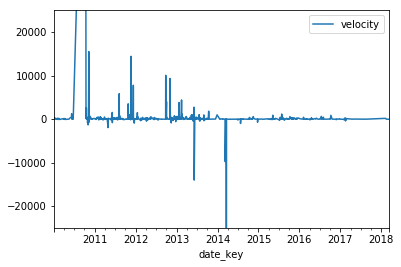

In [54]:
hmm.groupby('date_key').sum().plot()
plt.ylim(-25000,25000)
plt.show()

In [64]:
per = df.authored.dt.to_period('Y')

lucy = df[(df.owner_name == 'apache') & 
   (df.project_name == 'attic-lucy')][['owner_name', 'project_name', 
                                       'lines_added', 'lines_subtracted']].groupby([per, 'owner_name', 
                                                                                    'project_name']).sum()

In [68]:
lucy['velocity'] = lucy.lines_added - lucy.lines_subtracted

In [75]:
# Acceleration
v = lucy.velocity.values

#v1 = [v[i,1] - v[i-1,1] for i in range(1,v.shape[0])]
#v1[0] = v[0,1]

In [98]:
v1 = np.array([v[i] - v[i-1] if i > 0 else v[i] for i in range(v.shape[0])])

In [100]:
lucy['acceleration'] = v1

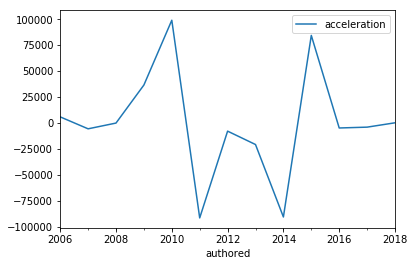

In [109]:
lucy.reset_index()[['authored', 'acceleration']].groupby('authored').sum().plot()
plt.show()

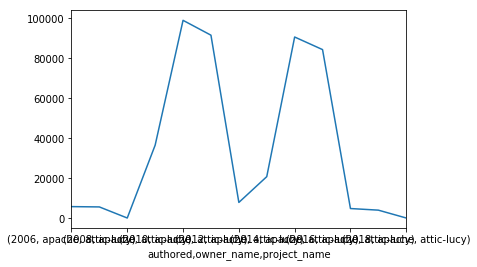

In [113]:
np.abs(lucy.acceleration).plot()
plt.show()

We can see that acceleration for Lucy converges to zero as the 
project is put in the Attic. Let's see if the same thing happens
for Wink.

In [115]:
per = df.authored.dt.to_period('Y')

wink = df[(df.owner_name == 'apache') & 
   (df.project_name == 'attic-wink')][['owner_name', 'project_name', 
                                       'lines_added', 'lines_subtracted']].groupby([per, 'owner_name', 
                                                                                    'project_name']).sum()
wink['velocity'] = wink.lines_added - wink.lines_subtracted

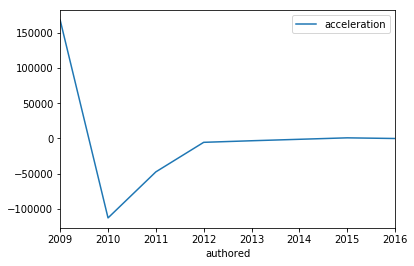

In [116]:
# Acceleration

v = wink.velocity.values
v1 = np.array([v[i] - v[i-1] if i > 0 else v[i] for i in range(v.shape[0])])
wink['acceleration'] = v1

wink.reset_index()[['authored', 'acceleration']].groupby('authored').sum().plot()
plt.show()

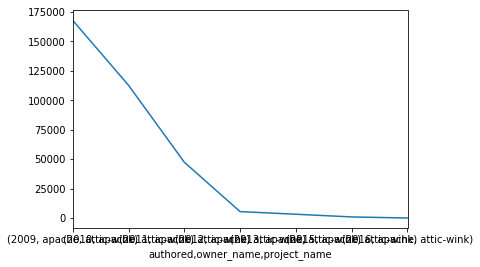

In [117]:
np.abs(wink.acceleration).plot()
plt.show()

Reviewing `Wink` and `Lucy` seem to make a pretty compelling case for
amplitude diverging from zero as being reasonable proxy for repo health
over time (see $H1_a$). The next step is to take this observation and convert it into
a statistical algorithm to predict future acceleration.

## Predicting Acceleration

Let's use some fany statistics and predict acceleration for each repo over time. We'll 
use year-to-year acceleration.

In [118]:
df.head()

,commit_hash,owner_name,project_name,file_id,modified_file,lines_added,lines_subtracted,name,email,authored
0,8c2ffd9174779014c3fe1f96d9dc3641d9175f00,torvalds,linux,0,Makefile,1,1,Linus Torvalds,torvalds@linux-foundation.org,2019-03-24 14:02:26
1,2a6a8e2d9004b5303fcb494588ba3a3b87a256c3,torvalds,linux,1,drivers/clocksource/clps711x-timer.c,13,32,Alexander Shiyan,shc_work@mail.ru,2018-12-20 14:16:26
2,18915b5873f07e5030e6fb108a050fa7c71c59fb,torvalds,linux,2,fs/ext4/ioctl.c,7,0,Darrick J. Wong,darrick.wong@oracle.com,2019-03-23 12:10:29
3,5e86bdda41534e17621d5a071b294943cae4376e,torvalds,linux,3,fs/ext4/indirect.c,22,25,zhangyi (F),yi.zhang@huawei.com,2019-03-23 11:56:01
4,674a2b27234d1b7afcb0a9162e81b2e53aeef217,torvalds,linux,4,fs/ext4/indirect.c,8,4,zhangyi (F),yi.zhang@huawei.com,2019-03-23 11:43:05


In [162]:
# Compute acceleration

def acceleration(v):
    """ Convert velocity vector to acceleration """
    v1 = [v[i] - v[i-1] if i > 0 else v[i] for i in range(v.shape[0])]
    return v1

def acceleration_per_repo(df, period):
   
    cols = ['authored','owner_name', 'project_name', 
            'lines_added', 'lines_subtracted']
    
    per = df.authored.dt.to_period(period)
    grp = [per,'owner_name', 'project_name']
    
    dfgrp = df[cols].groupby(grp).sum()
    dfgrp['velocity'] = dfgrp.lines_added - dfgrp.lines_subtracted
    dfgrp = dfgrp.reset_index()
    
    igrp = ['owner_name', 'project_name']
    dfgrp['acceleration'] = 0.0
    for i, row in dfgrp[igrp].groupby(igrp).count().reset_index().iterrows():
        
        subdf = dfgrp[(dfgrp.owner_name == row.owner_name) & (dfgrp.project_name == row.project_name)]
        v = subdf.velocity.values
        acc = acceleration(v)
        dfgrp.loc[(dfgrp.owner_name == row.owner_name) & 
           (dfgrp.project_name == row.project_name), 'acceleration'] = acc
        
    return dfgrp
    
    

In [163]:
# Compute amplitude

dfyr = acceleration_per_repo(df, 'Y')

In [165]:
# Check regression

dfyr.shape

(78, 7)

In [39]:
# Add any variables which could threaten validity as controls 
# see if the relationship still holds

